# GEOG788P Term Project
__"Food flows between counties in the United States": Visualization and Analysis__ 

__Brian Slobotsky__

My project is based on a paper published this year in Environmental Research Letters by Lin et al entitled [“Food flows between counties in the United States.”](https://iopscience.iop.org/article/10.1088/1748-9326/ab29ae) The paper used national and subnational data sources to create a model which spatially downscaled commodity flow data to the county scale. 

So far, I have created a visualization of the dataset with the `plotly` module. I have also created an interactive map which utilizes a Python GUI (via `tkinter`) to allow a user to limit the visualization to a single county, a single commodity category, or switch the flow direction. The output is a `folium` choropleth map.

Additionally, I intend to use exploratory spatial data analysis to investigate the spatial interaction of the model. So far, I have created a contiguity matrix. I will investigate if there is spatial autocorrelation globally, if there are meaningful residuals, and where similar values are clustering.

Please refer to the comments throughout my code in order to follow my step by step process.

## Data pre-processing

The data in this project comes from three main sources. The first is the paper mentioned above. The second is a table of FIPS codes (5 digit unique values for county-level identification) from the US Census Bureau, which is used to convert FIPS codes in the other two data sources to the names of counties or county equivalents. The third is a shapefile of US counties, read into a geodataframe.

In [1]:
import pandas as pd
import geopandas as gp
import numpy as np
import cenpy
import matplotlib.pyplot as plt
from tkinter import *
import folium
import plotly.graph_objects as go
from plotly import offline
from math import log10
import webbrowser
import os
from pysal.lib.weights import weights

C:\Users\Brian\Anaconda\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning:

You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`

C:\Users\Brian\Anaconda\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning:

The `dill` module is required to use the sqlite backend fully.



In [2]:
## loading data ##
# paper data
f = 'erl_14_8_084011_sd_3.csv'
db = pd.read_csv(f)

## setting up dictionary between stcg category names and data column abbreviations
sctg_dict = {'Live Animals and Fish':'sctg_1', 
             'Cereal Grains (including seed)':'sctg_2',
             'Agricultural Products except Animal Feed, Cereal Grains, and Forage Products':'sctg_3',
             'Animal Feed, Eggs, Honey, and Other Products of Animal Origin':'sctg_4',
             'Meat, Poultry, Fish, Seafood, and Their Preparations':'sctg_5',
             'Milled Grain Products and Preparations, and Bakery Products':'sctg_6',
             'Other Prepared Foodstuffs, Fats and Oils':'sctg_7',
             'Total':'total'}
## variable with category names
ckeys = list(sctg_dict.keys())

## changing fips codes into five digits
a = []
for i in db['ori']:
    i = str(i)
    i = i.zfill(5)
    a.append(i)
db['ori'] = a

b = []
for i in db['des']:
    i = str(i)
    i = i.zfill(5)
    b.append(i)
db['des'] = b
dbi = db.copy()             ## making a copy for later

# census data 
fips = cenpy.explorer.fips_table("county")

## creating a fips code column
fips[5] = ""
fips[6] = ""

a = [] 
for i in fips[1]:
    i = str(i)
    i = i.zfill(2)
    a.append(i)
fips[5] = a

b = []
for i in fips[2]:
    i = str(i)
    i = i.zfill(3)
    b.append(i)
fips[6] = b

fips[7] = fips[5] + fips[6]

## tidying data
fips.columns = ['state','col2','col3','name','col5','FIPS_state','FIPS_county','FIPS']
fips.drop(['col2','col3','col5'],axis=1, inplace = True)
fips = fips[fips.FIPS_state < '57']

fips['fullname'] = fips['name'] + ", " + fips['state']

## creating a dictionary with county names and FIPS codes
fipsdict = dict(zip(fips['fullname'],fips['FIPS']))
## assigning county names to a variable
dkeys = list(fipsdict.keys())

# geographic data
gdf = gp.read_file("counties.shp")

## Plotly Map

The main flow map is a work in progress due to the large amount of data. The code below will show only the first 2000 flows (out of more than 160,000) as a HTML file in a new tab of your browser.

In [8]:
# preparing data for main flow map
## getting coordinates from centroids for each county
countypoints = gdf.copy()
countypoints['x'] = countypoints['geometry'].centroid.x
countypoints['y'] = countypoints['geometry'].centroid.y
countypoints.drop(['geometry'],axis=1, inplace = True)
## merging coordinates to paper data by FIPS code
### for origin county
db = db[db.ori != db.des]                    ## removing intra-county flows to improve performance
merged = db.merge(countypoints, how = 'left', left_on='ori', right_on='FIPS')
merged['olong'], merged['olat'] = merged['x'], merged['y']
merged.drop(['FIPS','x','y'],axis=1, inplace = True)
### for destination county
latlong_db = merged.merge(countypoints, how = 'left', left_on='des', right_on='FIPS')
latlong_db['dlong'], latlong_db['dlat'] = latlong_db['x'], latlong_db['y']
latlong_db.drop(['FIPS','x','y'],axis=1, inplace = True)

# using plotly for main flow map
fig = go.Figure()
## creating lines with a for loop
for i in range(2000):
    fig.add_trace(
        go.Scattergeo(
            ## using lines and markers
            mode = 'lines+markers',
            lon = [latlong_db['olong'][i], latlong_db['dlong'][i]],
            lat = [latlong_db['olat'][i], latlong_db['dlat'][i]],
            ## line width, marker size, and opacity based on 'total' column
            line = dict(width = log10(float(latlong_db['total'][i])) / log10(float(latlong_db['total'].max()))
                        ,color = 'red'),
            marker = dict(size = 5 * (log10(float(latlong_db['total'][i])) / log10(float(latlong_db['total'].max())))),
            opacity = 0.05 * (log10(float(latlong_db['total'][i])) / log10(float(latlong_db['total'].max()))),
            ## no legend or hovering
            showlegend = False,
            hoverinfo = 'skip'
        )
    )
## custom layout
fig.update_layout(
    autosize = False,
    width = 900,
    height = 600,
    margin = go.layout.Margin(l=0, r=0, b=0, t=0, pad=0),
    title_text = '<br>Food flows between counties in the United States',
    ## setting view and projection
    geo = go.layout.Geo(scope = 'north america', projection_type = 'azimuthal equidistant')
)
## displaying the map
offline.plot(fig, filename='plotly_project.html')

'plotly_project.html'

## Interactive Folium Map

The user interface below will launch a pop-up window where you can refine the map to a single county, a single commodity category, or reverse the flow direction visualization between origin and destination. The output will open in a new tab in your browser as a HTML file. To make a new selection, you will need to launch the user interface again by running the block of code again.  

In [4]:
# defining a function to convert user inputs into geojson file
def select_county(geo_input, dir_input, com_input):
    ## defining "geo_val" as the fips equivalent of a user inputted county
    geo_val = fipsdict.get(geo_input)
    ## defining "com_val" as the sctg column equivalent of a user inputted sctg category
    com_val = sctg_dict.get(com_input)
    ## limit to origin db val (single county selection)
    limval = db[db.ori == geo_val]
    if dir_input == 'Origin':
        ## grouping by destination (destination counties for one origin county)
        limval = limval.groupby(['des'])[com_val].sum()
    else:
        ## grouping by origin (origin counties for one destination county)
        limval = limval.groupby(['ori'])[com_val].sum()  
    ## converting back to dataframe
    dfval = pd.DataFrame({'FIPS':limval.index, com_val:limval.values})
    ## join total value to gdf by the FIPS column
    gdf_new = gdf.merge(dfval, how = 'left', on='FIPS')
    ## creating a name column using the fips dictionary to be used in the hovering functionality
    a = []
    for i in gdf_new['FIPS']:
        ## avoiding an indexing error by using try and except statements
        try: i = dkeys[list(fipsdict.values()).index(i)]
        except: i = 'NaN'
        finally: a.append(i)
    gdf_new['name'] = a
    ## replacing NaN with 0
    gdf_new[com_val] = gdf_new[com_val].replace(np.nan, 0)
    gdf_new['val'] =  gdf_new[com_val]
    ## deleting counties with 0 values to create a manageable geojson size
    gdf_new = gdf_new.loc[gdf_new.val > 0, ['FIPS','geometry','name','val']] 
    gdf_new['val'] = gdf_new['val'].round(2)
    ## avoiding error if dataframe is empty (invalid choice combination)
    if gdf_new.empty == False:
        ## gdf to geojson
        gdf_new.to_file("output.geojson", driver="GeoJSON")
        ## creating a csv file needed in later code
        df1 = pd.DataFrame(gdf_new)
        df1.to_csv('gdf.csv')
    else:
        ## writing or overwriting the csv to be blank to avoid showing a map from a past request
        with open("gdf.csv", "w") as blank_csv:
            blank_csv.close()
        ## alerting user of error
        print('Input combination does not exist. Please try another combination')

In [10]:
## User interface using the tkinter module ##

# setting the window design
root = Tk()
mainframe = Frame(root)
mainframe.grid(column=0,row=0,sticky=(N,W,E,S))
mainframe.columnconfigure(0, weight = 1)
mainframe.rowconfigure(0, weight = 1)
mainframe.pack(pady = 100, padx = 100)

# three user inputs
## first, choosing a county
### setting the variable
tkvar_geo = StringVar(root)
tkvar_geo.set('')                ## no default value
choices_geo = dkeys              ## list of items are the keys from the fips dictionary

### formatting 
popupMenu_geo = OptionMenu(mainframe, tkvar_geo, *choices_geo)
popupMenu_geo.grid(row = 0, column = 1, sticky = W)
Label(mainframe, text="Select a county:").grid(row = 0, column = 0, sticky = W)

## second, switching between "origin" and "destination"
### setting the variable
tkvar_dir = StringVar(root)
tkvar_dir.set('Origin')             ## setting origin as default
choices_dir = ['Origin', 'Destination']

### formatting
popupMenu_dir = OptionMenu(mainframe, tkvar_dir, *choices_dir)
popupMenu_dir.grid(row = 2, column = 1, sticky = W)
Label(mainframe, text="Change flow direction:").grid(row = 2, column = 0, sticky = W)

## third, selecting a SCTG category
### setting the variable
tkvar_com = StringVar(root)
choices_com = ckeys                 ## list of items are the keys from the sctg dictionary
tkvar_com.set('Total')              ## setting total as default

### formatting
popupMenu_com = OptionMenu(mainframe, tkvar_com, *choices_com)
popupMenu_com.grid(row = 4, column = 1, sticky = W)
Label(mainframe, text="Select a commodity category:").grid(row = 4, column = 0, sticky = W)

# adding window title and exit button
root.title('Input Window')
exitButton = Button(root, text = 'Done', command = root.destroy)
exitButton.pack(side = 'bottom')
root.mainloop()

# assigning user inputs to variables
geo_input = tkvar_geo.get()
dir_input = tkvar_dir.get()
com_input = tkvar_com.get()


## using the user inputs to create folium map ##

select_county(geo_input, dir_input, com_input)

# conditionally displaying the map if combination exists
try:
    ## csv is needed for values in folium
    outcsv = pd.read_csv('gdf.csv')
    stop = False
except:
    ## if csv is blank from earlier, this code will run
    stop = True
    
# displaying the map only for possible combinations
if stop == False:
    ## need to tidy data again by dropping unneccessary columns and making all FIPS codes 5 digits
    outcsv = outcsv.drop(outcsv.columns[[0, 2]], axis=1)
    a = []
    b = []
    for i in outcsv['FIPS']:
        i = str(i)
        i = i.zfill(5)
        a.append(i)
        try: c = dkeys[list(fipsdict.values()).index(i)]
        except: c = 'NaN'
        finally: b.append(c)
    outcsv['FIPS'] = a
    outcsv['name'] = b
    
    ## message to user showing the final selection
    print('You are viewing {0} flows with {1} as the {2} county'.format(com_input, geo_input, dir_input.lower()))
    
    ## folium choropleth mapping
    
    ### basemap
    m = folium.Map(location=[39.8, -98.5],tiles='cartodbpositron', prefer_canvas = True, zoom_start = 3)
    ### choropleth
    choro = folium.Choropleth(geo_data="output.geojson",
                              data = outcsv,
                              name = 'Choropleth',
                              columns = ['FIPS','val'],
                              key_on='properties.FIPS',
                              fill_color='YlGn', fill_opacity=0.5, line_opacity=0.5,
                              legend_name = com_input + " flow destinations, measured in kilograms"
                             ).add_to(m)
    ### hover functionality
    choro.geojson.add_child(folium.features.GeoJsonTooltip(
        fields=['name','val'],
        aliases=['County name:','Value (kg):']
    ))
    ### red outline for the selected county 
    polygon = gdf.loc[gdf.FIPS == fipsdict.get(geo_input), ['geometry']]
    folium.GeoJson(polygon, tooltip=geo_input, name=geo_input, 
                   style_function=lambda x: {'color':'#ff0000','fillColor': 'none'}
                  ).add_to(m)
    ### allowing layers to be turned off
    folium.LayerControl().add_to(m)
    ### saving to an html and opening in web browser
    m.save('folium_project.html')
    webbrowser.open('file://' + os.path.realpath('folium_project.html'))

You are viewing Total flows with Maricopa County, AZ as the origin county


## Exploratory Spatial Data Analysis

For some additional analysis, I decided to conduct some exploratory spatial data analysis. Below, you can see how I constructed a contiguity matrix using the food flow data.

In [11]:
# creating a contiguity matrix
## creating a list of unique counties and setting empty dictionaries 
uni = dbi.des.unique()
neigh = {}
weight = {}
## for each unique origin county, finding its destination counties and total values
for i in range(len(uni)):
    try: 
        ## if the county is an origin county, this code will run 
        orilim = dbi[dbi.ori == uni[i]]
        ## converting columns to lists
        des = orilim.des.tolist()
        tot = orilim.total.tolist()
    except:
        ## if the county is only a destination county, this code will run
        des = ['NaN']
        tot = ['NaN']
    finally:
        ## adding lists as dictionary values
        neigh[uni[i]] = des
        weight[uni[i]] = tot
## using the two dictionaries to construct a weights matrix
w = weights.W(neigh, weight)

C:\Users\Brian\Anaconda\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning:

There are 20 disconnected observations 
  Island ids: 02050, 02070, 02150, 02164, 02170, 02180, 02188, 02220, 02240, 02261, 02290, 13025, 13319, 21203, 26039, 48105, 48267, 54007, 54093, 54109



Here is a histrogram of the matrix cardinalities. The mean ~51.6, and the standard deviation is ~57.7.

(51.59143222506394, 57.736219227413265)

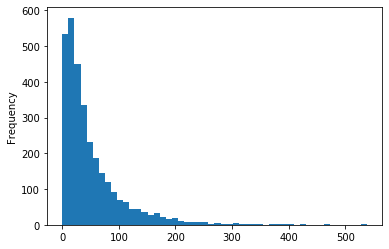

In [12]:
pd.Series(w.cardinalities).plot.hist(bins=50)
pd.Series(w.cardinalities).mean(), pd.Series(w.cardinalities).std()

To do: Find a way to get the weights matrix properly indexed with the `gdf` shapefile in order to conduct more spatial analysis. Here is code that does not work:

Error


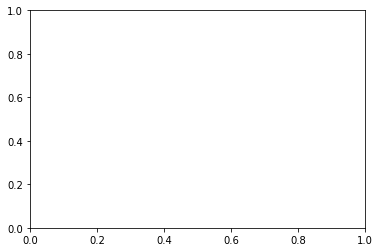

In [13]:
## limiting gdf by dropping FIPS outside the weights matrix
gdf_df = pd.DataFrame(data= {'FIPS': uni})
gdf_df['y'] = 1
gdf_lim = gdf.merge(gdf_df, how = 'left', on='FIPS')
gdf_lim = gdf_lim[gdf_lim.y == 1]
gdf_lim = gdf_lim.drop('y', axis = 1)

try: w.plot(gdf_lim)
except: print('Error')